In [55]:
from __future__ import annotations
import io, os, re, math
from dataclasses import dataclass
from typing import Iterable, List, Tuple, Dict

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.ticker import ScalarFormatter

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

plt.rcParams.update({
    "figure.figsize": (7.2, 4.6),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 120,
})


## Load and clean the dataset

In [ ]:
# Data loading & cleaning
GRBWEB_TXT_URL = "https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt"

#Download and parse GRBweb Summary_table.txt into a tidy DataFrame
def fetch_grbweb_summary(url: str = GRBWEB_TXT_URL) -> pd.DataFrame:
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    raw = r.text.splitlines()
    if len(raw) < 3:
        raise RuntimeError("GRBweb file is too short.")
    header_line = raw[1]
    sep_re = re.compile(r"\s{2,}")
    names = [t.strip().replace(" ", "_") for t in sep_re.split(header_line.strip("# ")) if t.strip()]
    data_txt = "\n".join(raw[2:])
    #pass regex as *string*, not compiled pattern
    df = pd.read_csv(io.StringIO(data_txt), sep=r"\s{2,}", engine="python", names=names, dtype=str)
    # numeric where possible
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="ignore")
    return df

#Forces key column to be numeric and derives log10 columns
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ["T90","fluence","'T100'","redshift"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # positive-only logs
    for col in ["T90","fluence","'T100'", "redshift"]:
        if col in df.columns:
            df.loc[(df[col] <= 0) | ~np.isfinite(df[col]), col] = np.nan
            df[f"log10_{col}"] = np.log10(df[col])
    return df


In [57]:

df_raw = fetch_grbweb_summary()
df = clean_dataframe(df_raw)
display(df.head())
print(f"Rows: {len(df)}  |  Columns: {list(df.columns)[:8]} ... +{len(df.columns)-8} more")


GRB_name GRB_name_Fermi           T0          ra          decl  \
0            #          (UTC)   (°, J2000)  (°, J2000)  (°, 1-sigma)   
1   GRB250911A            NaN      1:27:46    263.7501      -16.8542   
2   GRB250910B            NaN     18:52:05     80.2000      -46.4000   
3   GRB250909A   GRB250909107      2:33:28     78.8400       39.5200   
4  GRB250905B*   GRB250905344  8:14:36.519    130.1100      -21.3900   

  pos_error     T90 T90_error    T90_start   fluence fluence_error  redshift  \
0       (s)     NaN     (UTC)   (erg/cm^2)       NaN           (s)       NaN   
1      -999     NaN      -999         -999       NaN          -999       NaN   
2      -999     NaN      -999         -999       NaN          -999       NaN   
3  3.289798  33.277    1.5570  2:33:28.886  0.000005    5.6518e-08       NaN   
4  8.293308  14.592    2.6360  8:14:36.519  0.000002    4.2908e-08       NaN   

   'T100' GBM_located      mjd_(T0)  log10_T90  log10_fluence  log10_'T100'  \
0     NaN        None           NaN        NaN            NaN           NaN   
1     NaN       False  60929.060949        NaN            NaN           NaN   
2     NaN        True  60928.786169        NaN            NaN           NaN   
3  34.163        True  60927.106574   1.522144      -5.311384      1.533556   
4  14.592        True  60923.343478   1.164115      -5.705225      1.164115   

   log10_redshift  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

Rows: 8867  |  Columns: ['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error', 'T90', 'T90_error'] ... +11 more


## Q1 & Q2 — Sub-populations and threshold (GMM on $\log_{10} T_{90}$)

In [58]:
from dataclasses import dataclass

@dataclass
class GMMSummary:
    gmm: GaussianMixture
    bic: Dict[int, float]
    n_components: int

#Fit with GMM models (1,2,3,4 gaussians) and for each compute the BIC
def fit_gmm_1d(x: np.ndarray, components: Iterable[int] = (1,2,3,4), random_state: int = 42) -> GMMSummary:
    x = x[np.isfinite(x)].reshape(-1, 1)
    bic = {}
    best = (None, None, np.inf)
    for k in components:
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
        gmm.fit(x)
        bic[k] = gmm.bic(x)
        if bic[k] < best[2]:
            best = (gmm, k, bic[k])
    return GMMSummary(gmm=best[0], bic=bic, n_components=best[1])

#Plot KDE
def hist_with_kde(ax, x: np.ndarray, bins: int = 50, label: str = None):
    x = x[np.isfinite(x)]
    ax.hist(x, bins=bins, density=True, alpha=0.5, edgecolor="k")
    if x.size > 1:
        kde = gaussian_kde(x)
        xs = np.linspace(np.nanmin(x), np.nanmax(x), 500)
        ax.plot(xs, kde(xs), lw=2, label=label or "KDE")
    if label: ax.legend(frameon=False)

#Plot the histogram, best GMM (and the single gaussian components) and KDE
def plot_gmm_1d(ax, x: np.ndarray, gmm: GaussianMixture, xlabel: str, title: str = ""):
    x = x[np.isfinite(x)]
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 800)
    logprob = gmm.score_samples(xs.reshape(-1, 1))
    pdf = np.exp(logprob)
    resp = gmm.predict_proba(xs.reshape(-1, 1))
    hist_with_kde(ax, x, bins=50)
    ax.plot(xs, pdf, lw=2.5, label=f"GMM (K={gmm.n_components})")
    for k in range(gmm.n_components):
        comp = resp[:, k] * pdf
        ax.plot(xs, comp, ls="--", lw=1.8, label=f"comp. {k+1}")
    ax.legend(frameon=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("density")
    ax.set_title(title)
    ax.margins(x=0.02, y=0.05)

#Find x-values (in log space) where adjacent components have equal posterior 
    # For each pair of adjacent Gaussian components we solve:
    #   w1 * N(x | m1, s1^2) = w2 * N(x | m2, s2^2)
    #
    # Step 1: Expand the Gaussian pdf
    #   (w1/s1) * exp(-(x-m1)^2 / (2*s1^2)) = (w2/s2) * exp(-(x-m2)^2 / (2*s2^2))
    #
    # Step 2: Take logarithms to simplify the exponentials
    #   log(w1/s1) - (x-m1)^2 / (2*s1^2) = log(w2/s2) - (x-m2)^2 / (2*s2^2)
    #
    # Step 3: Rearrange terms -> quadratic equation in x
    #   A*x^2 + B*x + C = 0
def equal_posterior_threshold_1d(gmm: GaussianMixture) -> List[float]:
    means = gmm.means_.ravel()
    stds = np.sqrt(np.array([np.diag(cov)[0] for cov in gmm.covariances_]))
    weights = gmm.weights_.ravel()
    order = np.argsort(means)
    means, stds, weights = means[order], stds[order], weights[order]
    roots = []
    for i in range(len(means)-1):
        m1, s1, w1 = means[i], stds[i], weights[i]
        m2, s2, w2 = means[i+1], stds[i+1], weights[i+1]
        A = 1/(2*s1**2) - 1/(2*s2**2)
        B = -m1/(s1**2) + m2/(s2**2)
        C = (m1**2)/(2*s1**2) - (m2**2)/(2*s2**2) - np.log((w2/s2)/(w1/s1))
        if abs(A) < 1e-12:
            x0 = -C / B
            roots.append(x0)
        else:
            disc = B**2 - 4*A*C
            if disc >= 0:
                r1 = (-B + np.sqrt(disc)) / (2*A)
                r2 = (-B - np.sqrt(disc)) / (2*A)
                cand = [r for r in (r1, r2) if min(m1,m2) <= r <= max(m1,m2)]
                if cand: roots.append(cand[0])
    return roots

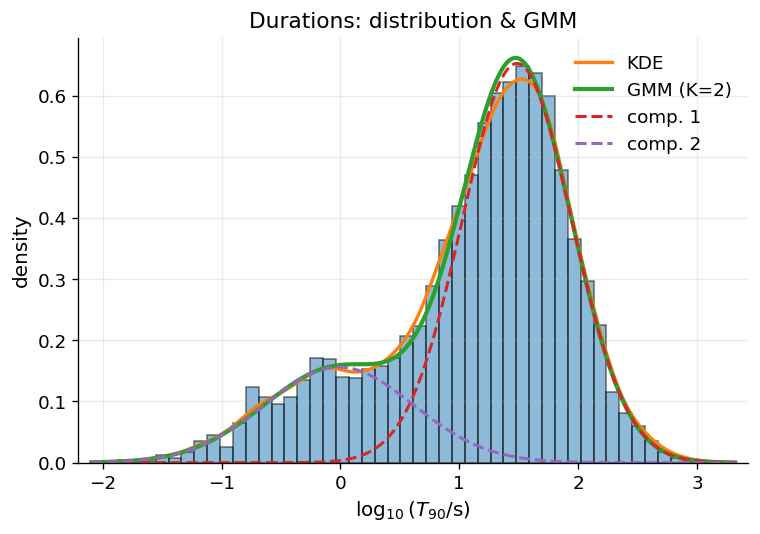


[GMM 1D on log10 T90] BIC by K:
  K=1: BIC=18783.8
  K=2: BIC=17181.9
  K=3: BIC=17239.3
  K=4: BIC=17282.2
Best K by BIC: 2
Equal-posterior threshold(s) in seconds: 13.9 s


In [ ]:

# Fit GMM on log10(T90) to see how many subpopulations are contained
x = df["log10_T90"].to_numpy()
gsum = fit_gmm_1d(x, components=(1,2,3,4))

fig, ax = plt.subplots()
plot_gmm_1d(ax, x, gsum.gmm, xlabel=r"$\log_{10}(T_{90}/\mathrm{s})$", title="Durations: distribution & GMM")
plt.show()

# Threshold(s) at equal posterior between adjacent components (in seconds)
roots_log = equal_posterior_threshold_1d(gsum.gmm)
thresholds_sec = [10**r for r in roots_log]

print("\n[GMM 1D on log10 T90] BIC by K:")
for k, v in sorted(gsum.bic.items()):
    print(f"  K={k}: BIC={v:.1f}")
print("Best K by BIC:", gsum.n_components)
if thresholds_sec:
    print("Equal-posterior threshold(s) in seconds:", ", ".join(f"{t:.3g} s" for t in thresholds_sec))

#(Q1): Does the distribution contain different sub-populations? How many?
# The 'Best K by BIC' K=2 suggests 2 populations (short vs long GRBs).

# (Q2): What's the threshold between the classes?
# Equal-posterior threshold(s) in seconds: 13.9 s


## Q3 — Compare clustering methods (GMM vs KMeans vs Mean-Shift) on [log10 T90, log10 fluence]

In [60]:
# 2D clustering (GMM, kmeans,mean-shift)
def cluster_2d(features: np.ndarray, method: str, n_clusters: int = None, random_state: int = 42):
    if method == "gmm":
        if n_clusters is None: raise ValueError("GMM requires n_clusters")
        model = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=random_state)
        labels = model.fit_predict(features)
        return labels, model
    elif method == "kmeans":
        if n_clusters is None: raise ValueError("KMeans requires n_clusters")
        model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
        labels = model.fit_predict(features)
        return labels, model
    elif method == "meanshift":
        # data-driven bandwidth 
        bw = estimate_bandwidth(features, quantile=0.20, n_samples=min(500, len(features)))
        if bw <= 0 or not np.isfinite(bw):  # fallback
            bw = None
        model = MeanShift(bandwidth=bw, bin_seeding=True)
        labels = model.fit_predict(features)
        return labels, model
    else:
        raise ValueError("method must be 'gmm', 'kmeans', or 'meanshift'")

[['log10_T90', 'log10_fluence']] K=2: ARI(GMM vs KMeans) = 0.784


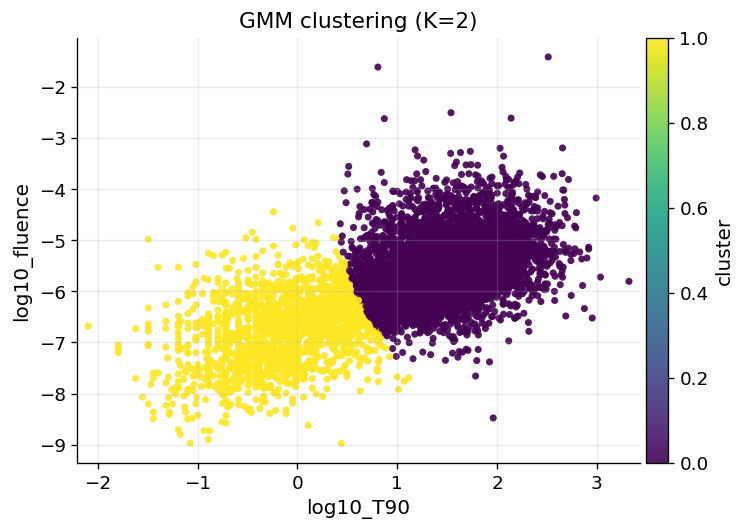

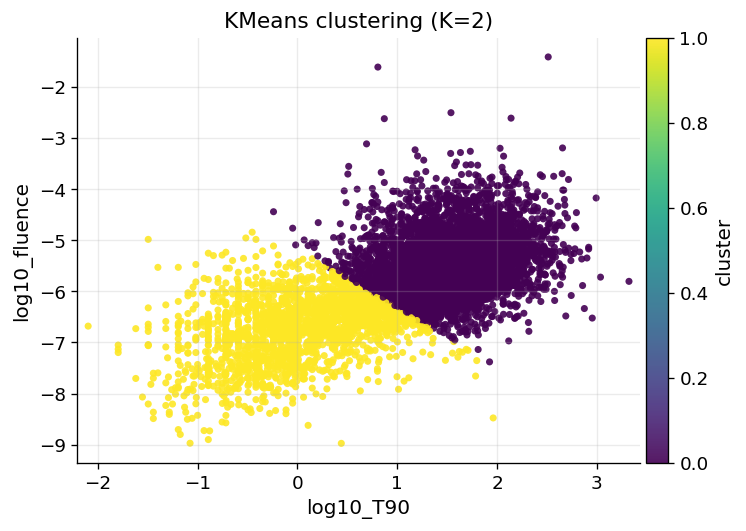

[['log10_T90', 'log10_fluence']] K=3: ARI(GMM vs KMeans) = 0.630


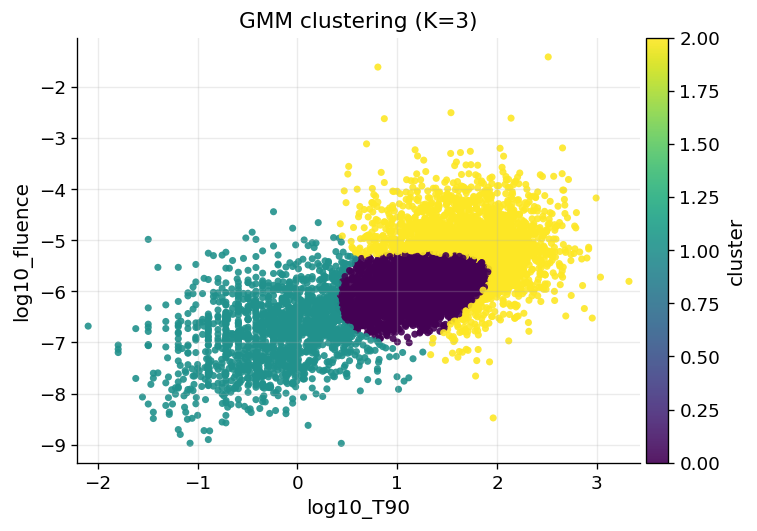

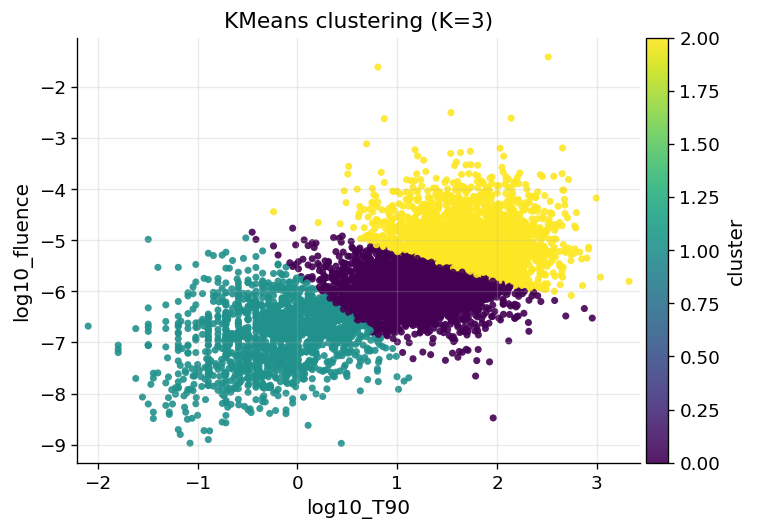

[['log10_T90', 'log10_fluence']] K=4: ARI(GMM vs KMeans) = 0.642


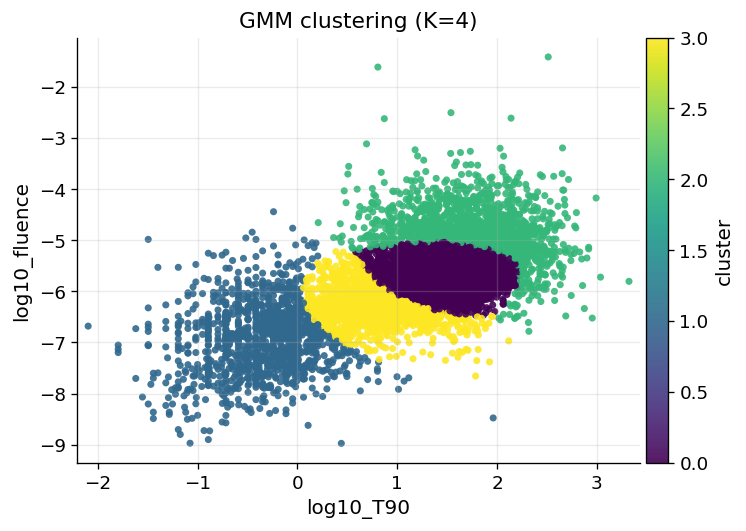

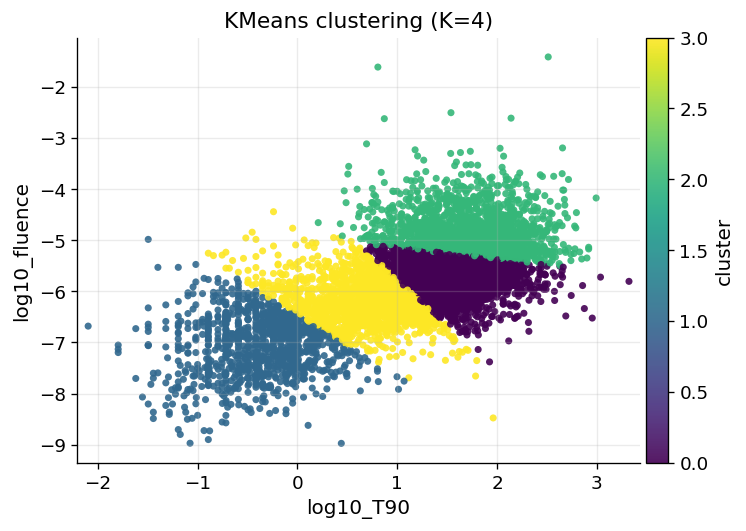

Mean-Shift discovered K=4 clusters (automatic).


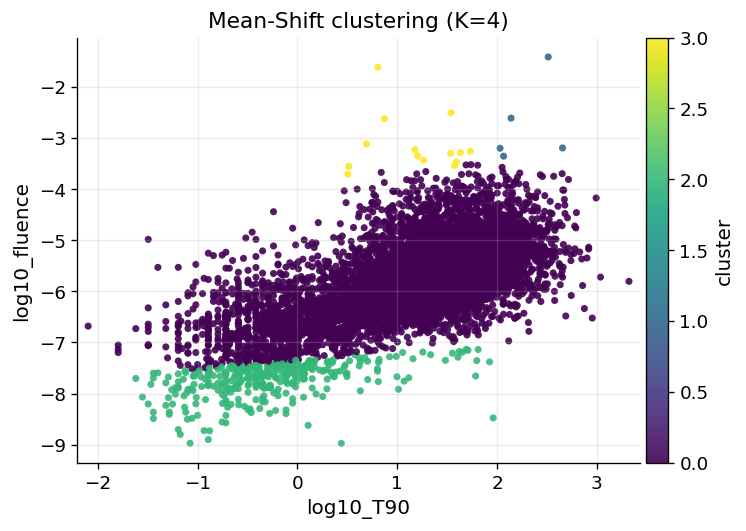

ARI(Mean-Shift vs GMM with K=4) = 0.049


In [ ]:

features, feat_names = [], []
if "log10_T90" in df.columns:
    features.append(df["log10_T90"].to_numpy()); feat_names.append("log10_T90")
if "log10_fluence" in df.columns:
    features.append(df["log10_fluence"].to_numpy()); feat_names.append("log10_fluence")

if len(features) >= 2:
    X = np.vstack(features).T
    mask = np.all(np.isfinite(X), axis=1)
    X = X[mask]
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    #GMM and k-mean (we have to set the number of cluster): compare with ARI
    for K in (2, 3, 4):
        gmm_labels, gmm_model = cluster_2d(Xs, method="gmm", n_clusters=K)
        km_labels, km_model = cluster_2d(Xs, method="kmeans", n_clusters=K)
        ari = adjusted_rand_score(gmm_labels, km_labels)
        print(f"[{feat_names}] K={K}: ARI(GMM vs KMeans) = {ari:.3f}")
        for name, labels in (("GMM", gmm_labels), ("KMeans", km_labels)):
            fig, ax = plt.subplots()
            sc = ax.scatter(X[:,0], X[:,1], c=labels, s=18, alpha=0.9, edgecolors="none")
            cbar = fig.colorbar(sc, ax=ax, pad=0.01); cbar.set_label("cluster")
            ax.set_xlabel(feat_names[0])
            ax.set_ylabel(feat_names[1])
            ax.set_title(f"{name} clustering (K={K})")
            ax.margins(x=0.02, y=0.05)
            plt.show()

    # Mean-Shift (automatic number of clusters)
    ms_labels, ms_model = cluster_2d(Xs, method="meanshift", n_clusters=None)
    n_ms = len(np.unique(ms_labels))
    print(f"Mean-Shift discovered K={n_ms} clusters (automatic).")
    fig, ax = plt.subplots()
    sc = ax.scatter(X[:,0], X[:,1], c=ms_labels, s=18, alpha=0.9, edgecolors="none")
    cbar = fig.colorbar(sc, ax=ax, pad=0.01); cbar.set_label("cluster")
    ax.set_xlabel(feat_names[0])
    ax.set_ylabel(feat_names[1])
    ax.set_title(f"Mean-Shift clustering (K={n_ms})")
    ax.margins(x=0.02, y=0.05)
    plt.show()

    # Optionally compare ARI vs the method with K matching Mean-Shift (only meaningful if same K)
    if n_ms in (2, 3, 4):
        gmm_labels_match, _ = cluster_2d(Xs, method="gmm", n_clusters=n_ms)
        print(f"ARI(Mean-Shift vs GMM with K={n_ms}) = {adjusted_rand_score(ms_labels, gmm_labels_match):.3f}")
else:
    print("Not enough features for 2D clustering.")
    


## Q4 — How do methods respond to outliers?


=== Q4: Sensitivity to outliers (stability metrics) ===
GMM  K=2 | ARI(clean vs all on clean)=0.916 | silhouette all=0.529 → clean=0.521 | mean center shift=0.080 (['log10_T90', 'log10_fluence'] units)
GMM  K=3 | ARI(clean vs all on clean)=0.627 | silhouette all=0.345 → clean=0.384 | mean center shift=0.065 (['log10_T90', 'log10_fluence'] units)
GMM  K=4 | ARI(clean vs all on clean)=0.667 | silhouette all=0.317 → clean=0.333 | mean center shift=0.099 (['log10_T90', 'log10_fluence'] units)
KMEANS  K=2 | ARI(clean vs all on clean)=0.912 | silhouette all=0.517 → clean=0.509 | mean center shift=0.087 (['log10_T90', 'log10_fluence'] units)
KMEANS  K=3 | ARI(clean vs all on clean)=0.862 | silhouette all=0.385 → clean=0.389 | mean center shift=0.090 (['log10_T90', 'log10_fluence'] units)
KMEANS  K=4 | ARI(clean vs all on clean)=0.788 | silhouette all=0.339 → clean=0.340 | mean center shift=0.142 (['log10_T90', 'log10_fluence'] units)

Mean-Shift: K(all)=4  vs  K(clean)=1
Mean-Shift changed t

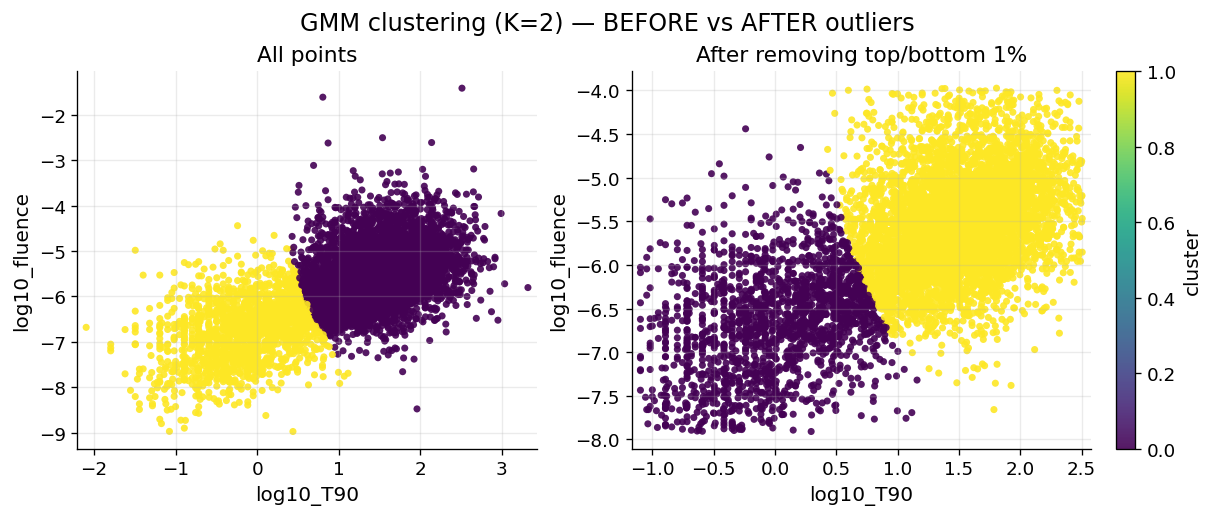

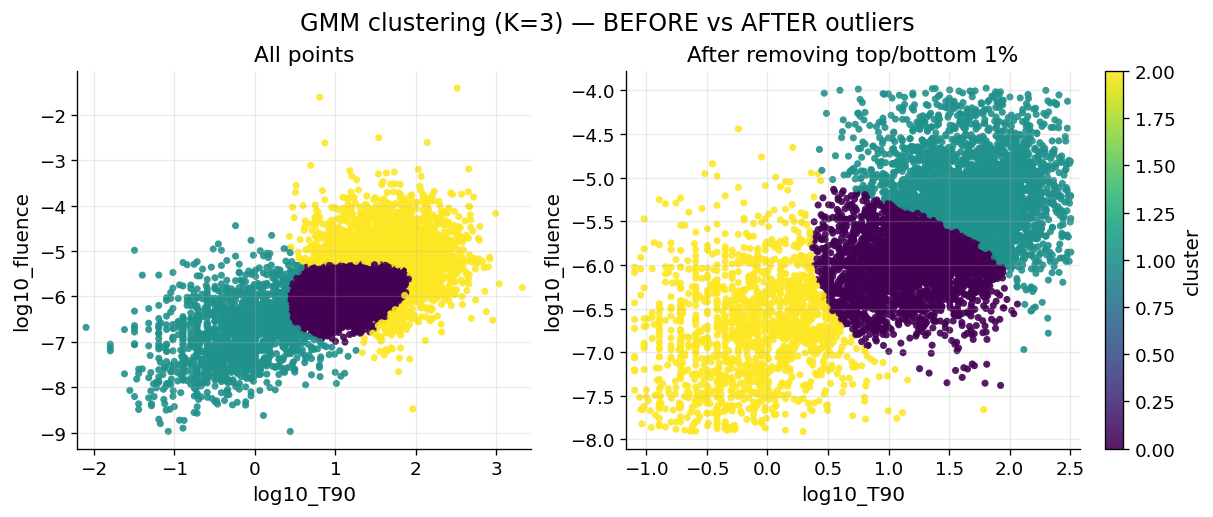

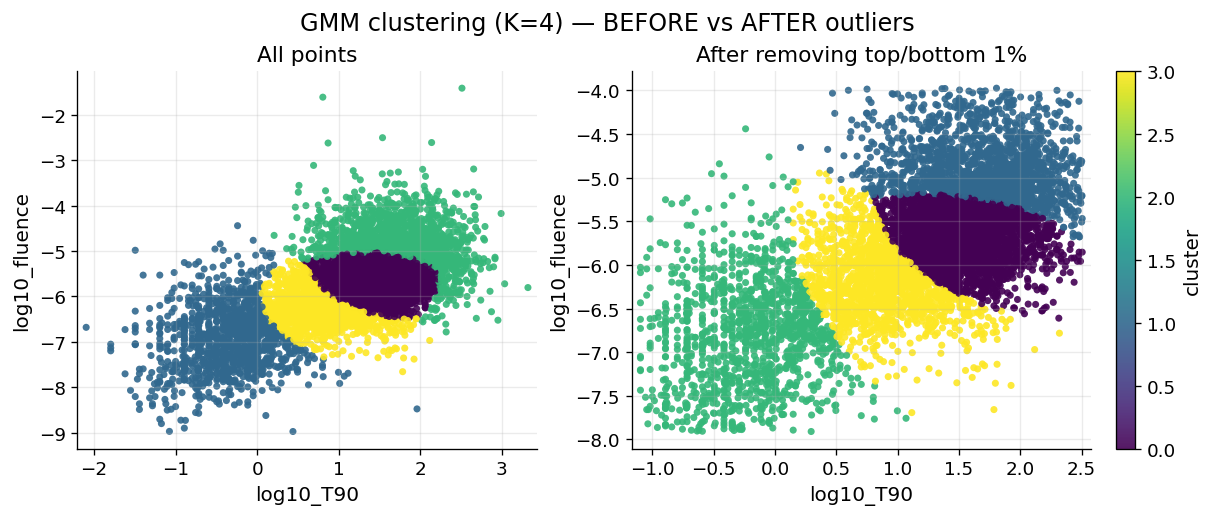

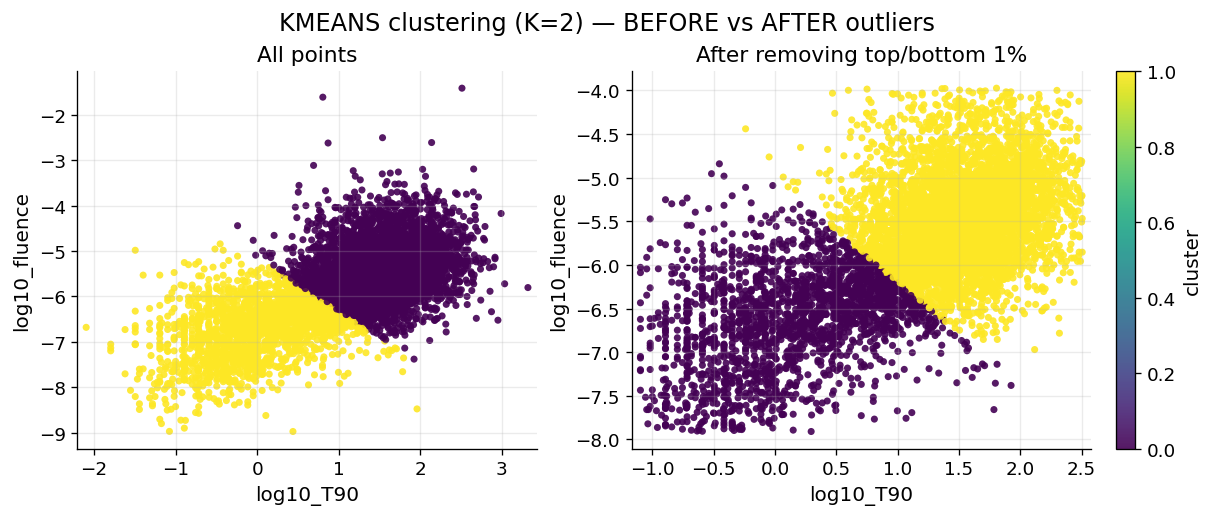

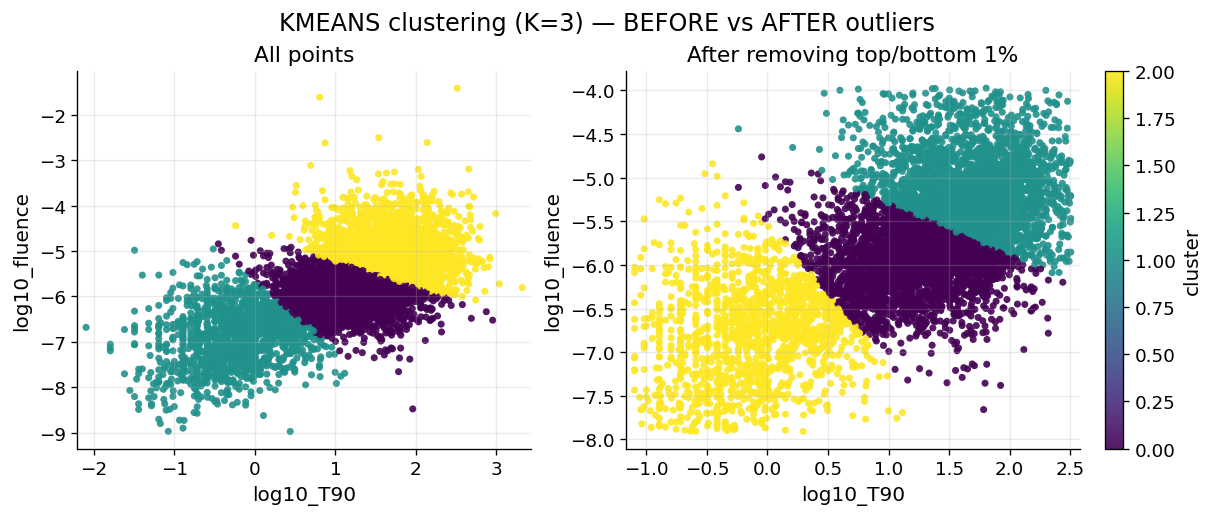

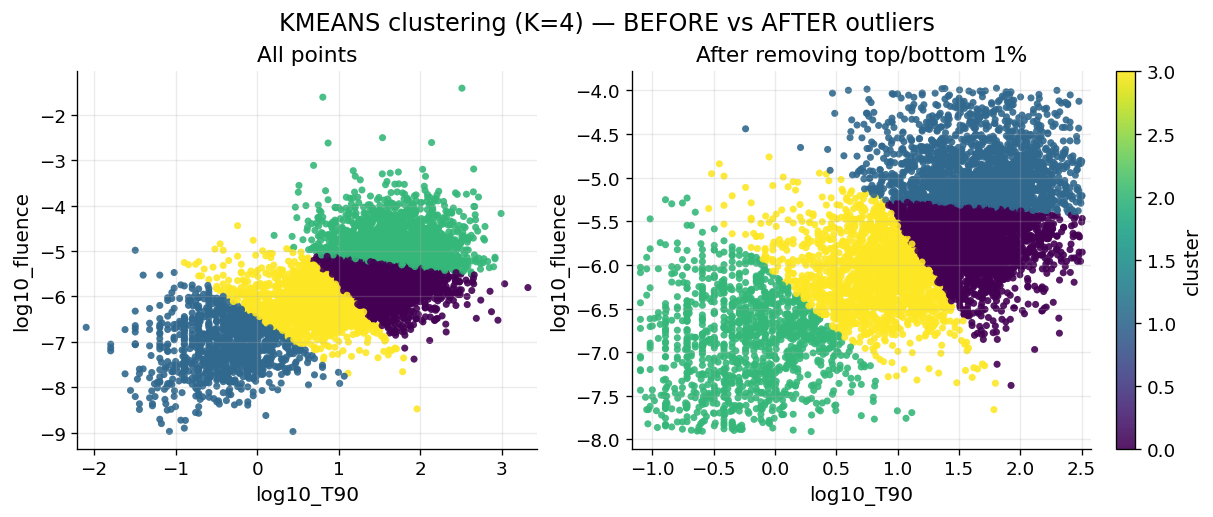

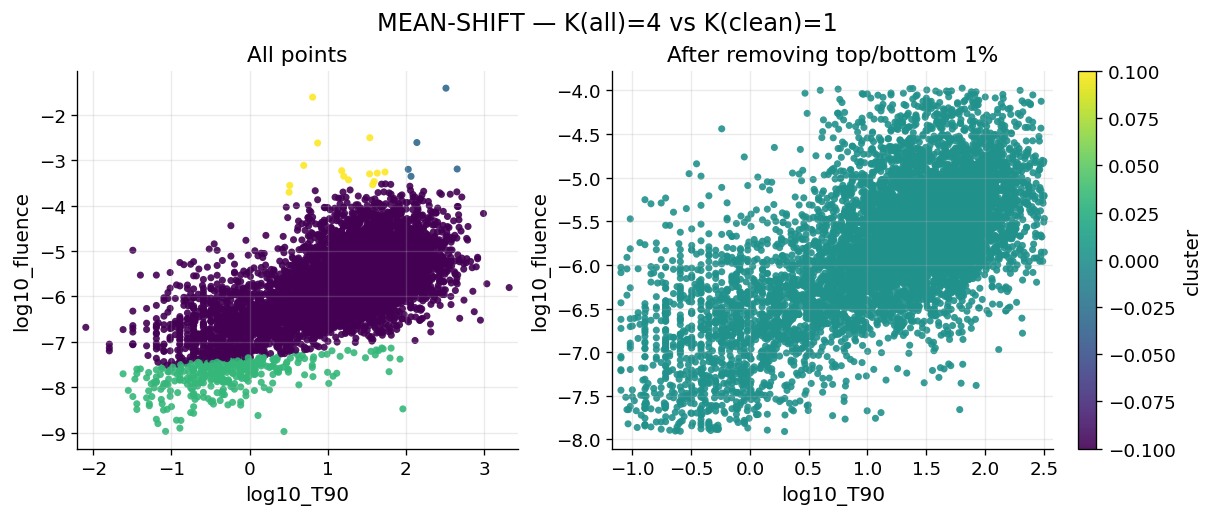

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

#Removes outliers: keeps only the rows whose values lie within the central [1−q, q] quantile (q=0.99 (1%))
def remove_outliers_quantile(df: pd.DataFrame, cols: List[str], q: float = 0.99) -> pd.DataFrame:
    dfc = df.copy()
    mask = np.ones(len(dfc), dtype=bool)
    for c in cols:
        if c in dfc.columns:
            lo, hi = dfc[c].quantile(1-q), dfc[c].quantile(q)
            mask &= (dfc[c] >= lo) & (dfc[c] <= hi)
    return dfc.loc[mask]

#Bring centers (fit in standardized space) back to original feature units (xs= (x-mu)/sigma) to evaluate the mean-shift
def inverse_transform_centers(centers_z, scaler):
    return centers_z * scaler.scale_ + scaler.mean_

#Align labels of y_b to y_a via Hungarian assignment on the contingency matrix (based on how many points are in each cluster)
def align_labels(y_a, y_b):
    C = contingency_matrix(y_a, y_b) 
    r_ind, c_ind = linear_sum_assignment(C.max() - C)
    mapping = {c: r for r, c in zip(r_ind, c_ind)}
    y_b_aligned = np.vectorize(lambda t: mapping.get(t, t))(y_b)
    return y_b_aligned, mapping

# Fit GMM, KMeans (with specified Ks) and MeanShift on standardized X
def fit_predict_all_methods(X, K_list=(2,)):
    out = {"gmm": {}, "kmeans": {}, "meanshift": {}}
    for K in K_list:
        lbl, mdl = cluster_2d(X, method="gmm", n_clusters=K)
        out["gmm"][K] = (lbl, mdl)
        lbl, mdl = cluster_2d(X, method="kmeans", n_clusters=K)
        out["kmeans"][K] = (lbl, mdl)
    # MeanShift (K automatic)
    lbl, mdl = cluster_2d(X, method="meanshift", n_clusters=None)
    out["meanshift"][len(np.unique(lbl))] = (lbl, mdl)
    return out

#Plot the clusters before and after the removal of outliers
def plot_before_after(X_all, y_all, X_clean, y_clean, title, feat_names):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.2), constrained_layout=True)
    sc0 = axes[0].scatter(X_all[:, 0], X_all[:, 1], c=y_all, s=18, alpha=0.9, edgecolors="none")
    axes[0].set_title("All points")
    axes[0].set_xlabel(feat_names[0]); axes[0].set_ylabel(feat_names[1]); axes[0].margins(x=0.02, y=0.05)

    sc1 = axes[1].scatter(X_clean[:, 0], X_clean[:, 1], c=y_clean, s=18, alpha=0.9, edgecolors="none")
    axes[1].set_title("After removing top/bottom 1%")
    axes[1].set_xlabel(feat_names[0]); axes[1].set_ylabel(feat_names[1]); axes[1].margins(x=0.02, y=0.05)

    cbar = fig.colorbar(sc1, ax=axes.ravel().tolist(), pad=0.02)
    cbar.set_label("cluster")
    fig.suptitle(title)
    plt.show()

if len(features) >= 2:
    X = np.vstack(features).T
    mask_all = np.all(np.isfinite(X), axis=1)
    X = X[mask_all]
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)

    # Remove top/bottom 1% per feature 
    X_df = pd.DataFrame(X, columns=feat_names)
    X_no_df = remove_outliers_quantile(X_df, cols=feat_names, q=0.99)
    Xs_no = scaler.transform(X_no_df.to_numpy())

    # Fit on ALL and on NO-OUTLIERS
    K_list = (2, 3, 4)  
    res_all = fit_predict_all_methods(Xs, K_list=K_list)
    res_no  = fit_predict_all_methods(Xs_no, K_list=K_list)

    print("\n=== Q4: Sensitivity to outliers (stability metrics) ===")
    for method in ("gmm","kmeans"):
        for K in K_list:
            y_all, mdl_all = res_all[method][K]
            y_no,  mdl_no  = res_no[method][K]

            # Compare on a common set of points:
            # use both models to predict labels on the same clean set (Xs_no)
            y_all_on_clean = mdl_all.predict(Xs_no)
            y_no_on_clean  = y_no  # labels from the model fitted on the clean set

            # Align labels to avoid permutation / label-switching issues
            y_no_on_clean_aligned, _ = align_labels(y_all_on_clean, y_no_on_clean)

            # ARI between labelings (partition stability on the clean set)
            ari_clean = adjusted_rand_score(y_all_on_clean, y_no_on_clean_aligned)

            # Silhouette (cohesion/separation) before vs after removing outliers
            sil_all = silhouette_score(Xs, y_all) if len(np.unique(y_all)) > 1 else np.nan
            sil_no  = silhouette_score(Xs_no, y_no_on_clean_aligned) if len(np.unique(y_no_on_clean_aligned)) > 1 else np.nan

            # Shift of cluster centers / means (in original feature units)
            if method == "kmeans":
                c_all = inverse_transform_centers(mdl_all.cluster_centers_, scaler)
                c_no  = inverse_transform_centers(mdl_no.cluster_centers_,  scaler)
            else:  # GMM
                c_all = inverse_transform_centers(mdl_all.means_, scaler)
                c_no  = inverse_transform_centers(mdl_no.means_,  scaler)

            # Align centers using the same label mapping
            # (mapping computed from predictions on Xs_no)
            _, mapping = align_labels(y_all_on_clean, y_no_on_clean)
            # mapping: label_no -> label_all
            # build a vector of shifts for corresponding clusters
            shifts = []
            for lbl_no, lbl_all in mapping.items():
                if lbl_no < c_no.shape[0] and lbl_all < c_all.shape[0]:
                    shifts.append(np.linalg.norm(c_all[lbl_all] - c_no[lbl_no]))
            mean_shift = np.mean(shifts) if shifts else np.nan

            print(f"{method.upper()}  K={K} | ARI(clean vs all on clean)={ari_clean:.3f} | "
                f"silhouette all={sil_all:.3f} → clean={sil_no:.3f} | "
                f"mean center shift={mean_shift:.3f} ({feat_names} units)")

# ---- Mean-Shift: K can change; report the change and, if equal, also ARI
ks_all = list(res_all["meanshift"].keys()); ks_no = list(res_no["meanshift"].keys())
y_all_ms, mdl_all_ms = res_all["meanshift"][ks_all[0]]
y_no_ms,  mdl_no_ms  = res_no["meanshift"][ks_no[0]]
print(f"\nMean-Shift: K(all)={ks_all[0]}  vs  K(clean)={ks_no[0]}")
if ks_all[0] == ks_no[0]:
    y_all_on_clean = mdl_all_ms.predict(Xs_no)
    y_no_on_clean  = y_no_ms
    y_no_on_clean_aligned, _ = align_labels(y_all_on_clean, y_no_on_clean)
    ari_ms = adjusted_rand_score(y_all_on_clean, y_no_on_clean_aligned)
    print(f"Mean-Shift ARI (clean vs all on clean) = {ari_ms:.3f}")
else:
    print("Mean-Shift changed the number of clusters after removing outliers (sensitive to bandwidth/density).")


#Plotting
# Raw (unscaled) matrices for plotting
X_no = X_no_df.to_numpy()

#GMM & KMeans (for K in K_list)
for method in ("gmm", "kmeans"):
    for K in K_list:
        y_all, mdl_all = res_all[method][K]
        y_no,  mdl_no  = res_no[method][K]
        plot_before_after(
            X_all=X, y_all=y_all,
            X_clean=X_no, y_clean=y_no,
            title=f"{method.upper()} clustering (K={K}) — BEFORE vs AFTER outliers",
            feat_names=feat_names
        )

#Mean-Shift (K may differ before/after)
ks_all = list(res_all["meanshift"].keys()); ks_no = list(res_no["meanshift"].keys())
y_all_ms, mdl_all_ms = res_all["meanshift"][ks_all[0]]
y_no_ms,  mdl_no_ms  = res_no["meanshift"][ks_no[0]]
plot_before_after(
    X_all=X, y_all=y_all_ms,
    X_clean=X_no, y_clean=y_no_ms,
    title=f"MEAN-SHIFT — K(all)={ks_all[0]} vs K(clean)={ks_no[0]}",
    feat_names=feat_names
)



## Q5 — Which variable(s) shows multimodality more evidently?

In [ ]:
#Evaluate BIC using GMM
def bic_multi_modal_score(x: np.ndarray, max_k: int = 3, random_state: int = 42) -> Dict[int, float]:
    x = x[np.isfinite(x)].reshape(-1, 1)
    bics = {}
    for k in range(1, max_k+1):
        g = GaussianMixture(n_components=k, random_state=random_state)
        g.fit(x)
        bics[k] = g.bic(x)
    return bics


In [ ]:

vars_to_test = [c for c in ("log10_T90", "log10_fluence", "log10_'T100'", "log10_redshift") if c in df.columns]
rows = []
for c in vars_to_test:
    b = bic_multi_modal_score(df[c].to_numpy(), max_k=3)
    dBIC = b.get(2, np.nan) - b.get(1, np.nan)  # negative -> K=2 preferred
    rows.append((c, b.get(1, np.nan), b.get(2, np.nan), dBIC))
res = pd.DataFrame(rows, columns=["variable","BIC(K=1)","BIC(K=2)","Delta = BIC2 - BIC1"])
display(res)

# (Q5) Which variable(s) shows multimodality more evidently?
# The variable with the most negative Delta (BIC2 - BIC1) exhibits clearer multimodality.
# log10_T90 shows the strongest evidence for multimodality (short vs long).


c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


variable      BIC(K=1)      BIC(K=2)  Delta = BIC2 - BIC1
0       log10_T90  18783.762408  17181.920691         -1601.841716
1   log10_fluence  18862.201801  18705.128882          -157.072919
2    log10_'T100'  18564.902298  17148.258716         -1416.643582
3  log10_redshift    895.985694    755.029842          -140.955852

## Q6 — Are all GRBs equally likely to be observed?

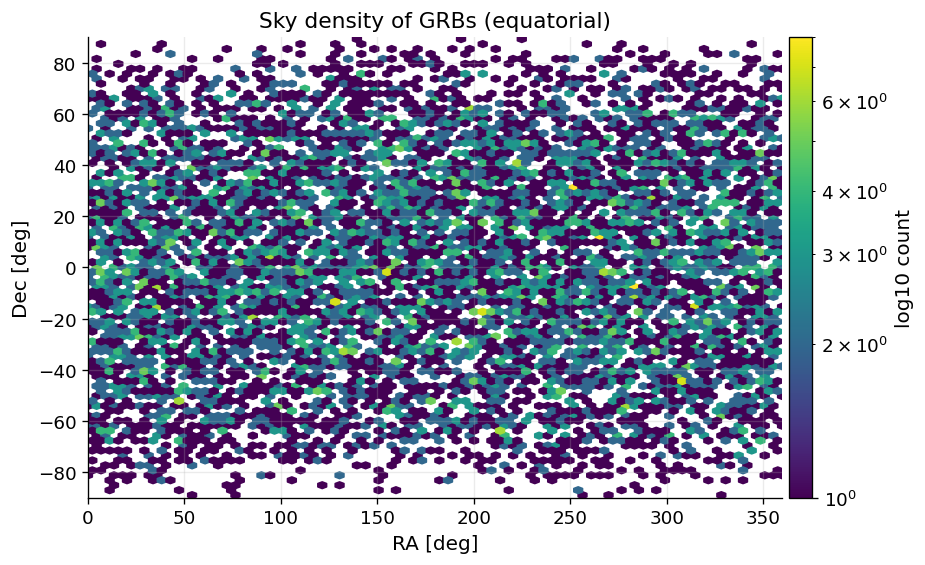

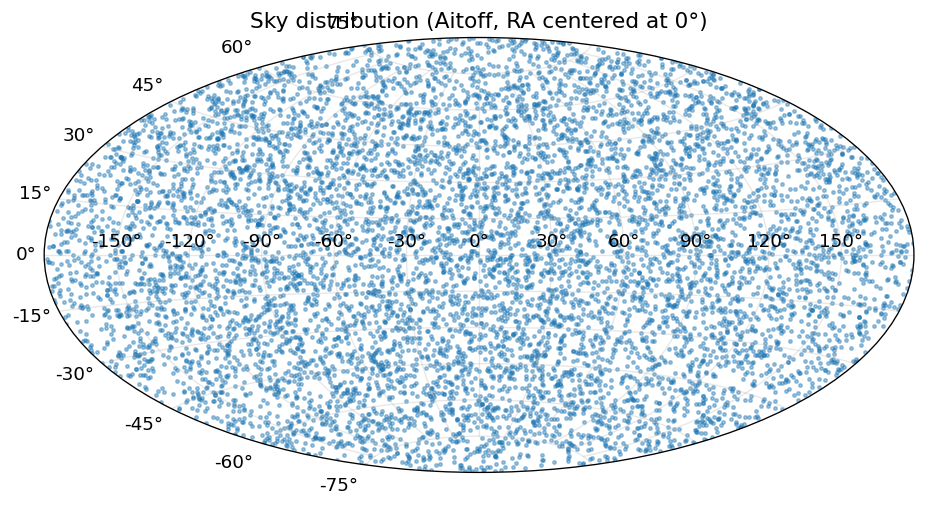

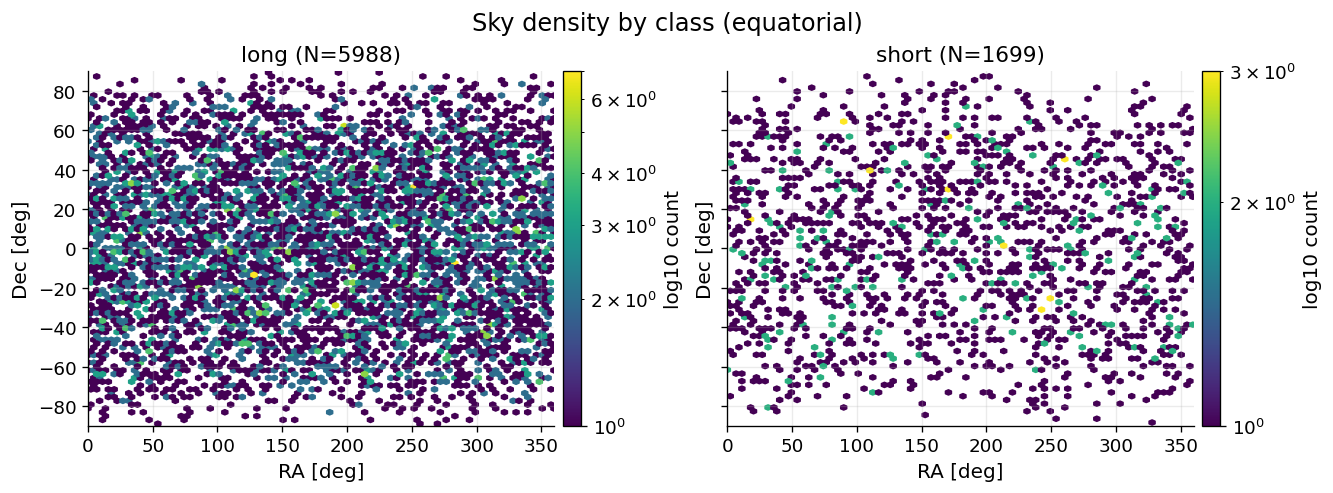

In [ ]:
# Overall sky maps  
if {"ra", "decl"}.issubset(df.columns): # requires 'ra' (Right Ascension) and 'decl' (Declination) (equatorial coordinates)
    # Convert to numeric and drop NaNs
    ra_all  = pd.to_numeric(df["ra"],   errors="coerce")
    dec_all = pd.to_numeric(df["decl"], errors="coerce")
    ok = ra_all.notna() & dec_all.notna()
    ra_all  = ra_all[ok].to_numpy()
    dec_all = dec_all[ok].to_numpy()

    # Equatorial density map via hexbin (log-scaled counts)
    # Note: hexbin in (RA, Dec) is not equal-area on the sphere
    fig, ax = plt.subplots(figsize=(7.6, 4.6), constrained_layout=True)
    hb = ax.hexbin(ra_all, dec_all, gridsize=80, bins="log", cmap="viridis")
    cb = fig.colorbar(hb, ax=ax, pad=0.01); cb.set_label("log10 count")
    ax.set_xlabel("RA [deg]"); ax.set_ylabel("Dec [deg]")
    ax.set_title("Sky density of GRBs (equatorial)")
    ax.set_xlim(0, 360); ax.set_ylim(-90, 90)
    plt.show()

    # Aitoff projection (wrap RA to [-180, 180] and convert to radians)
    ra_wrap = np.remainder(ra_all + 360 - 180, 360) - 180
    fig = plt.figure(figsize=(7.6, 4.2), constrained_layout=True)
    ax = fig.add_subplot(111, projection="aitoff")
    ax.scatter(np.deg2rad(ra_wrap), np.deg2rad(dec_all), s=4, alpha=0.4)
    ax.grid(True, alpha=0.3)
    ax.set_title("Sky distribution (Aitoff, RA centered at 0°)")
    plt.show()
else:
    print("Columns 'ra' and 'decl' not found; skipping overall sky maps.")

# Per-class sky density (short vs long) using GMM on log10_T90
if "log10_T90" in df.columns and {"ra", "decl"}.issubset(df.columns):
    x_all = df["log10_T90"].to_numpy()
    gmm_for_classes = fit_gmm_1d(x_all, components=(1, 2, 3, 4)).gmm

    # Keep rows with valid features for class assignment and sky plots
    mask = (
        np.isfinite(x_all) &
        pd.to_numeric(df["ra"],   errors="coerce").notna() &
        pd.to_numeric(df["decl"], errors="coerce").notna()
    )
    sub = df.loc[mask].copy()
    x = sub["log10_T90"].to_numpy().reshape(-1, 1)

    # Predict GMM component for each burst
    comp = gmm_for_classes.predict(x)

    # Order components by mean in log-space and map to semantic names
    order = np.argsort(gmm_for_classes.means_.ravel())
    rank_map = {comp_id: rank for rank, comp_id in enumerate(order)}   
    comp_ranked = np.vectorize(rank_map.get)(comp)
    names_by_rank = ["short", "long"][:gmm_for_classes.n_components]
    sub["class_T90"] = np.array([names_by_rank[r] for r in comp_ranked])

    # Hexbin per class (same axes and color scaling across panels)
    classes = sorted(sub["class_T90"].unique())
    fig, axes = plt.subplots(
        1, len(classes), figsize=(11, 4), constrained_layout=True, sharex=True, sharey=True
    )
    if len(classes) == 1:  # ensure 'axes' is iterable when K=1
        axes = [axes]

    for ax, cls in zip(axes, classes):
        d = sub[sub["class_T90"] == cls]
        ra_c  = pd.to_numeric(d["ra"],   errors="coerce")
        dec_c = pd.to_numeric(d["decl"], errors="coerce")
        ok = ra_c.notna() & dec_c.notna()
        hb = ax.hexbin(ra_c[ok], dec_c[ok], gridsize=80, bins="log", cmap="viridis")
        ax.set_xlim(0, 360); ax.set_ylim(-90, 90)
        ax.set_xlabel("RA [deg]"); ax.set_ylabel("Dec [deg]")
        ax.set_title(f"{cls} (N={ok.sum()})")
        cb = plt.colorbar(hb, ax=ax, pad=0.01); cb.set_label("log10 count")

    fig.suptitle("Sky density by class (equatorial)")
    plt.show()
else:
    print("Missing 'log10_T90' or RA/Dec; skipping per-class sky maps.")
